# Prediction Intervals via Bootstrapping

## Concept

- Train a model (e.g., a simple regression model) multiple times on different bootstrap samples of your dataset.
- Collect the predictions for each bootstrap run and calculate prediction intervals at each data point.

## Why It’s Useful

- Bootstrapping captures the variability in your data.
- Provides a non-parametric way to estimate the uncertainty when you don’t want to make strong assumptions about the model residuals.

## Outline

1. Split your data into training and test sets.
1. Generate multiple bootstrap samples from the training set.
1. Train a model (e.g., `LinearRegression` from `scikit-learn`) on each bootstrap sample.
1. Predict on the test set for each trained model.
1. Aggregate the predictions to compute means and percentiles (e.g., 5th and 95th).
1. Plot or tabulate to show the uncertainty range.

## Continuous data examples

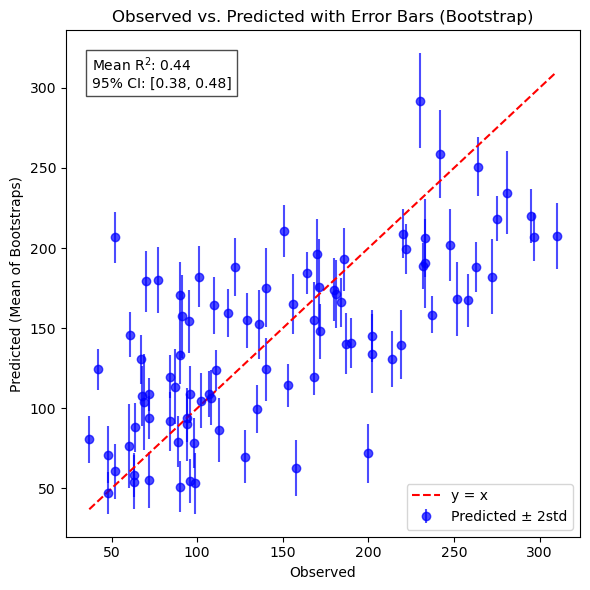

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score

# --- Control the Random Seed ---
seed = 42
np.random.seed(seed)

# --- Load the Data ---
X, y = load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Bootstrap Setup ---
n_bootstraps = 1000  # Adjust the number of bootstraps as desired
predictions_dict = {}
r2_scores = []

# --- Main Loop for Bootstrapping ---
for i in range(n_bootstraps):
    # Randomly sample indices (with replacement) from the training set
    bootstrap_indices = np.random.randint(0, len(X_train), size=len(X_train))
    X_boot = X_train[bootstrap_indices]
    y_boot = y_train[bootstrap_indices]

    # Train a simple model on the bootstrap sample
    model = LinearRegression()
    model.fit(X_boot, y_boot)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Store the predictions in a dictionary
    predictions_dict[f"bootstrap{i}"] = y_pred

    # Compute R^2 for this bootstrap and store it
    r2_scores.append(r2_score(y_test, y_pred))

# --- Convert the Dictionary to a DataFrame ---
predictions_df = pd.DataFrame(predictions_dict)

# --- Compute statistics across bootstraps ---
mean_predictions = predictions_df.mean(axis=1)
std_predictions = predictions_df.std(axis=1)

# --------------------------------------------------
#    Compute mean R^2 and a 95% CI via percentiles
# --------------------------------------------------
r2_mean = np.mean(r2_scores)

# For a bootstrap-based 95% CI, we can use percentiles
lower_ci = np.percentile(r2_scores, 2.5)
upper_ci = np.percentile(r2_scores, 97.5)

# # Alternatively, for a quick "parametric" style CI:
# r2_std = np.std(r2_scores, ddof=1)
# ci_half_width = 1.96 * r2_std / np.sqrt(n_bootstraps)
# lower_ci = r2_mean - ci_half_width
# upper_ci = r2_mean + ci_half_width

# --- Observed vs. Predicted (mean) with error bars ---
plt.figure(figsize=(6, 6))
plt.errorbar(
    x=y_test,
    y=mean_predictions,
    yerr=2 * std_predictions,  # 2 * std ~ approximate 95% range
    fmt="o",
    color="blue",
    alpha=0.7,
    label="Predicted ± 2std"
)

min_val = min(y_test.min(), mean_predictions.min())
max_val = max(y_test.max(), mean_predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], "--", color="red", label="y = x")

plt.xlabel("Observed")
plt.ylabel("Predicted (Mean of Bootstraps)")
plt.title("Observed vs. Predicted with Error Bars (Bootstrap)")

# --- Place text with R^2 info on the plot ---
r2_text = (
    f"Mean R$^2$: {r2_mean:.2f}\n"
    f"95% CI: [{lower_ci:.2f}, {upper_ci:.2f}]"
)
plt.text(
    0.05, 0.95,    # X, Y coordinates in Axes fraction
    r2_text,
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7)
)

plt.legend()
plt.tight_layout()
plt.show()


If each point represents a physical location, you can start to look for areas where predictions are less certain. This can help you identify where to collect more data or where to focus your attention.

Mean R^2 over 1000 splits: 0.483
Standard Error of R^2: 0.002
R^2 = 0.483 ± 0.002


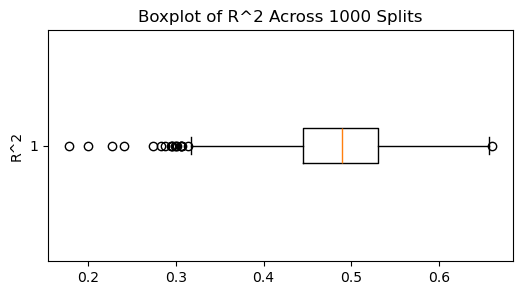

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score

# --- Control the Random Seed ---
seed = 101
np.random.seed(seed)

# --- Load the Data ---
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# ----------------------------------------------
#   Repeat 50 random splits and compute R^2
# ----------------------------------------------
n_splits = 1000
r2_scores = []

for i in range(n_splits):
    # Create a new train/test split each time
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        random_state=seed + i + 42  # or None for full randomness
    )
    
    # Train a simple linear model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Compute and store the R^2 score
    r2_scores.append(r2_score(y_test, y_pred))

# ----------------------------------------------
#   Compute mean R^2 and standard error
# ----------------------------------------------
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores, ddof=1)
standard_error = r2_std / np.sqrt(n_splits)

print(f"Mean R^2 over {n_splits} splits: {r2_mean:.3f}")
print(f"Standard Error of R^2: {standard_error:.3f}")
print(f"R^2 = {r2_mean:.3f} ± {standard_error:.3f}")

# ----------------------------------------------
#   Boxplot of the R^2 distribution
# ----------------------------------------------
plt.figure(figsize=(6, 3))
plt.boxplot(r2_scores, vert=False)
plt.ylabel("R^2")
plt.title(f"Boxplot of R^2 Across {n_splits} Splits")
plt.show()


## Binary data examples

Bootstrap AUC = 0.929 ± 0.000


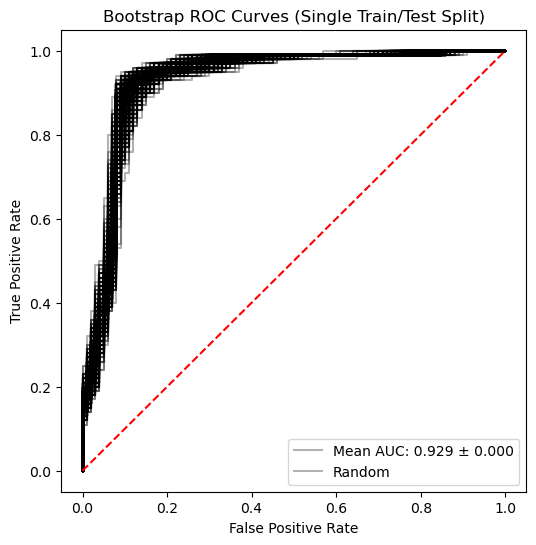

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# -------------------------------
#     Load and Prepare Data
# -------------------------------
# X, y = load_breast_cancer(return_X_y=True)
X, y = make_classification(
    n_samples=1000,
    n_classes=2,
    random_state=1729,
)

seed = 42
np.random.seed(seed)

# One-time train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# -------------------------------
#    Bootstrap Parameters
# -------------------------------
n_bootstraps = 1000  # You can adjust higher if desired
auc_scores = []

# Store the fpr/tpr for plotting each iteration's ROC curve
roc_curves = []  # will store tuples of (fpr, tpr)

# -------------------------------
#       Bootstrap Loop
# -------------------------------
for i in range(n_bootstraps):
    # Resample indices (with replacement) from X_train
    bootstrap_indices = np.random.randint(0, len(X_train), size=len(X_train))
    X_boot = X_train[bootstrap_indices]
    y_boot = y_train[bootstrap_indices]
    
    # Fit model on the bootstrap sample
    model = LogisticRegression(solver='liblinear', random_state=seed + i)
    model.fit(X_boot, y_boot)
    
    # Predict probabilities for the test set
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves.append((fpr, tpr))
    
    # Compute AUC
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

# -------------------------------
#   Compute Mean AUC ± SE
# -------------------------------
auc_mean = np.mean(auc_scores)
auc_std = np.std(auc_scores, ddof=1)
standard_error = auc_std / np.sqrt(n_bootstraps)

print(f"Bootstrap AUC = {auc_mean:.3f} ± {standard_error:.3f}")

# -------------------------------
#     Plot All ROC Curves
# -------------------------------
plt.figure(figsize=(6, 6))
for (fpr, tpr) in roc_curves:
    plt.plot(fpr, tpr, color='black', alpha=0.3)

# Plot a reference line for random classifier
plt.plot([0, 1], [0, 1], 'r--', label='Random')

# Annotate the mean AUC
label_text = f"Mean AUC: {auc_mean:.3f} ± {standard_error:.3f}"
plt.title("Bootstrap ROC Curves (Single Train/Test Split)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend([label_text, 'Random'])
plt.show()


Repeated Splits AUC = 0.950 ± 0.000


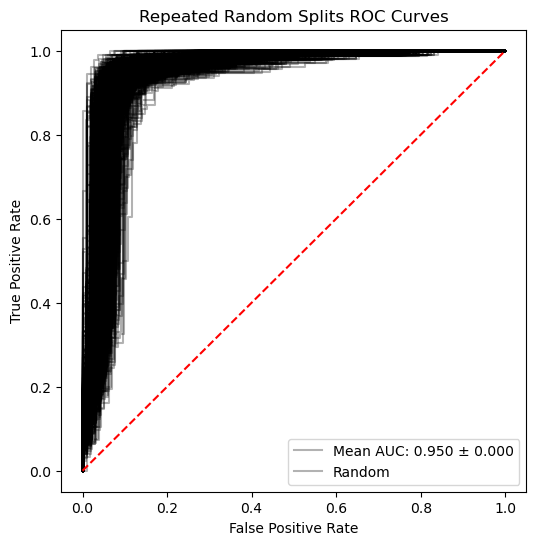

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# -------------------------------
#    Load and Prepare Data
# -------------------------------
X, y = make_classification(
    n_samples=1000,
    n_classes=2,
    random_state=1729,
)

seed = 101
np.random.seed(seed)

# -------------------------------
#     Repeatable Splits
# -------------------------------
n_splits = 1000  # Number of random splits
auc_scores = []
roc_curves = []

for i in range(n_splits):
    # Each loop does a fresh train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed + i  # controls how we shuffle each split
    )
    
    # Fit the model
    model = LogisticRegression(solver='liblinear', random_state=seed + i)
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    roc_curves.append((fpr, tpr))
    auc_scores.append(auc)

# -------------------------------
#   Compute Mean AUC ± SE
# -------------------------------
auc_mean = np.mean(auc_scores)
auc_std = np.std(auc_scores, ddof=1)
standard_error = auc_std / np.sqrt(n_splits)

print(f"Repeated Splits AUC = {auc_mean:.3f} ± {standard_error:.3f}")

# -------------------------------
#     Plot All ROC Curves
# -------------------------------
plt.figure(figsize=(6, 6))
for (fpr, tpr) in roc_curves:
    plt.plot(fpr, tpr, color='black', alpha=0.3)

# Plot a reference line for random classifier
plt.plot([0, 1], [0, 1], 'r--', label='Random')

# Annotate the mean AUC
label_text = f"Mean AUC: {auc_mean:.3f} ± {standard_error:.3f}"
plt.title("Repeated Random Splits ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend([label_text, 'Random'])
plt.show()
